# DATASET
The dataset consists of about 45000 articles of fake as well as real news. Our aim is train our model so that it can correctly predict whether a given piece of news is real or fake. The fake and real news data is given in two separate datasets with each dataset consisting around 20000 articles.

# Loading the required Libraries

In [40]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)


# Importing the Dataset

In [2]:
T = pd.read_csv('data/True.csv')
F = pd.read_csv('data/Fake.csv')

In [3]:
T.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


### Adding the label 1 and 0 for True and Fake News respectively

In [4]:
F['label'] = 0
T['label'] = 1

In [5]:
df = pd.concat([F, T])

### Showing that dataset is balanced

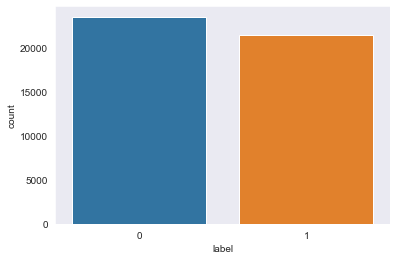

In [6]:
sn.set_style('dark')
sn.countplot(df.label)

In [7]:
#Chacking for Na values in the dataset
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [8]:
#Total number of news clippings
df.label.count()


44898

In [9]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

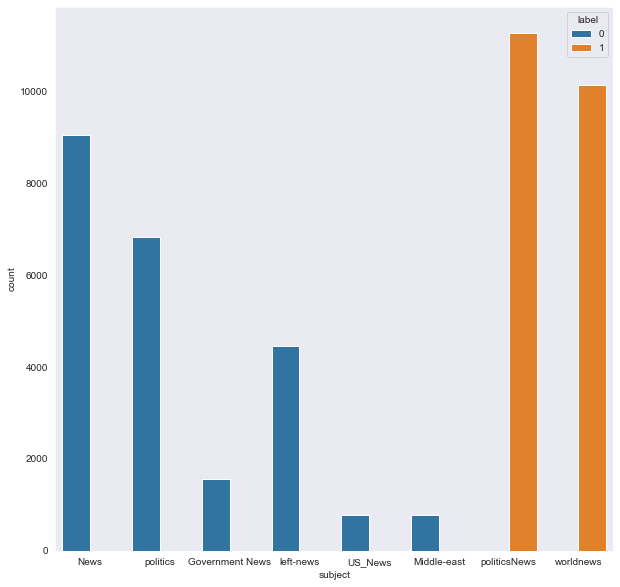

In [10]:
plt.figure(figsize = (10,10))
chart = sn.countplot(x= 'subject', hue = 'label', data = df)

#### Merging the text data into 1 column "text"

In [11]:
df['text'] = df['text'] + " " + df['title']

#### Excluding the "subject" column since topics are different for both categories

In [12]:
del df['title']
del df['date']
del df['subject']

In [13]:
df.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


# Text Cleaning

In [14]:
# Remove URL
def remove_URL(text):
    return re.sub(r'https?://\S+|www\.\S+', '',text)

# Remove square brackets
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

# Remove html tags
def remove_html(text):
    return re.sub(r'<.*?>', '', text)
remove_html("<h1>Vansh Jatana</h1>")

#Stemming
def stemming(text):
    text = text.lower().split(" ")
    
    porter_stemmer = nltk.PorterStemmer()
    roots = [porter_stemmer.stem(each) for each in text]
    return roots

# Remove StopWords
stop = set(stopwords.words('english'))
def remove_stopwords(text):
    res = []
    for word in text.split():
        if word.strip().lower() not in stop:
            res.append(word.strip())
    return " ".join(res)


#remove the noisy text
def remove_noise(text):
    text = remove_URL(text)
    text = remove_between_square_brackets(text)
    text = remove_html(text)
    text = remove_stopwords(text)
    text = stemming(text)
    return text

#Apply the remove_noise function 
df['text'] = df['text'].apply(remove_noise)

In [15]:
df.head()

,text,label
0,Donald Trump wish Americans Happy New Year lea...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"Friday, revealed former Milwaukee Sheriff Davi...",0
3,"Christmas day, Donald Trump announced would ba...",0
4,Pope Francis used annual Christmas Day message...,0


#### Shuffling and Splitting the data into Train(80%) and Test(20%) sets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, test_size= 0.2, random_state=0)

###### Tokenizing Text -> Repsesenting each word by a number

Mapping of orginal word to number is preserved in word_index property of tokenizer

Tokenized applies basic processing like changing it to lower case, explicitely setting that as False

Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones

In [17]:
embedding_size = 50
max_features = 50000
maxlen = 300

In [18]:
token = Tokenizer(num_words=max_features)
token.fit_on_texts(X_train)
tokenized_train = token.texts_to_sequences(X_train)
tokenized_test = token.texts_to_sequences(X_test)

In [19]:
X_train = pad_sequences(tokenized_train, maxlen=maxlen)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)
X_test.shape

(8980, 300)

# GloVe method 

GloVe method is built on the idea that you can derive semantic relationships between words from the co-occurrence matrix.
Given a corpus having V words, the co-occurrence matrix X will be a V x V matrix, where the i th row and j th column of X, X_ij denotes how many times word i has co-occurred with word j.

We are using a pretrained Word Embedding model (GloVe), which has 50 features for each word

In [55]:
embedding_index = dict()
f = open('data/glove.6B.50d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embedding_index[word] = coefs
f.close()

In [21]:
all_embs = np.stack(embedding_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]


nb_words = min(max_features, len(token.word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in token.word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

C:\Users\Umair\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


## Training the Model

In [43]:
model=Sequential()
X = model.add(Embedding(max_features, input_length=maxlen, 
        output_dim=embedding_size, weights=[embedding_matrix], trainable= False))
X = model.add(Bidirectional(LSTM(50, return_sequences = True, dropout=0.1, recurrent_dropout=0.1)))
X = model.add(GlobalMaxPool1D())
X = model.add(Dense(50, activation='relu'))
X = model.add(Dropout(0.1))
X = model.add(Dense(1, activation='sigmoid'))

In [44]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 50)           2500000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 300, 100)          40400     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 2,545,501
Trainable params: 45,501
Non-trainable params: 2,500,000
_______________________________________

In [45]:
history = model.fit(X_train, y_train, batch_size=32, epochs=3, validation_split=0.1)

Train on 32326 samples, validate on 3592 samples
Epoch 1/3
32326/32326 [==============================] - 1362s 42ms/step - loss: 0.1109 - accuracy: 0.9565 - val_loss: 0.0278 - val_accuracy: 0.9894
Epoch 2/3
32326/32326 [==============================] - 1356s 42ms/step - loss: 0.0257 - accuracy: 0.9909 - val_loss: 0.0142 - val_accuracy: 0.9953
Epoch 3/3
32326/32326 [==============================] - 1358s 42ms/step - loss: 0.0149 - accuracy: 0.9946 - val_loss: 0.0061 - val_accuracy: 0.9986


# Training and Validation Accuracy

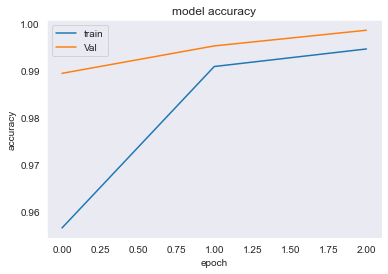

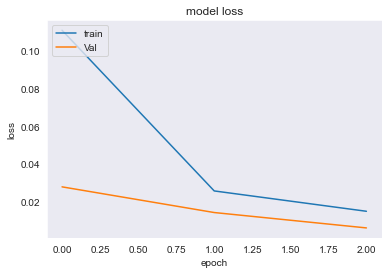

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

# Test Accuracy

In [47]:
preds = model.evaluate(X_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

8980/8980 [==============================] - 21s 2ms/step
Loss = 0.010294013560853561
Test Accuracy = 0.9973273873329163


In [49]:
Prediction = model.predict_classes(
    X_test)

# F1 Score

In [50]:
print(classification_report(y_test, Prediction, target_names = ['Fake (Class 0)','True (Class 1)']))

                precision    recall  f1-score   support

Fake (Class 0)       1.00      1.00      1.00      4713
True (Class 1)       1.00      1.00      1.00      4267

      accuracy                           1.00      8980
     macro avg       1.00      1.00      1.00      8980
  weighted avg       1.00      1.00      1.00      8980



# Confusion Matrix

[[4699   14]
 [  10 4257]]


Text(70.0, 0.5, 'Predicted')

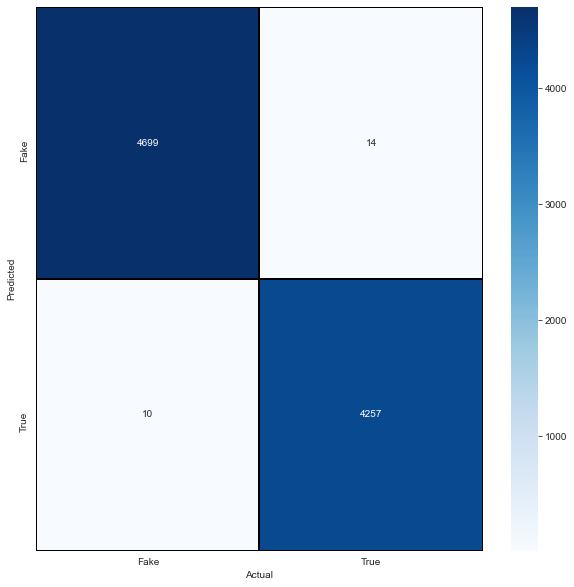

In [56]:
cm = confusion_matrix(y_test,Prediction)
print(cm)
plt.figure(figsize = (10,10))
sn.heatmap(cm,cmap= "Blues", xticklabels = ['Fake','True'], 
           yticklabels = ['Fake','True'],
           linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
plt.xlabel('Actual')
plt.ylabel('Predicted')